## Descenso de gradiente para regresión lineal

En el ejercicio anterior aprendiste regresión lineal y encontraste una solución analítica a través de algebra lineal, ahora resolveremos el mismo problema llegando a la solución de manera iterativa. 

En la práctica, descenso de gradiente se utiliza en problemas en los que obtener una solución analítica no es posible como regresión logística o redes neuronales.

(200, 2) (100, 2)


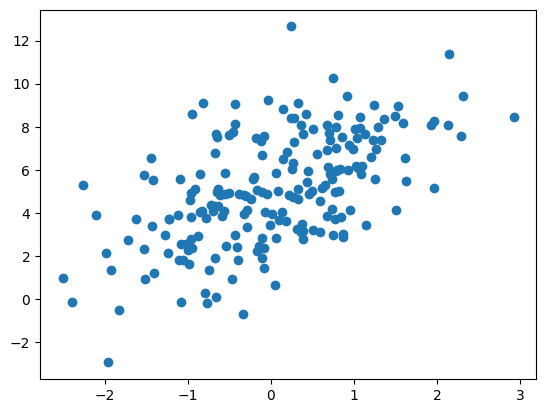

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Nuevamente generamos los datos aleatorios con una desviación estandar conocida
# Alrededor de una funcion lineal conocida y = 1.2x + 0.7
n_samples = 300
ruido_blanco_std = 2
X = np.random.randn(n_samples, 1)
for_bias = np.ones([n_samples, 1])
X_augmented = np.concatenate([for_bias, X], axis=-1)
eps = np.random.randn(n_samples, 1) * ruido_blanco_std
ideal_w = [[5], [1.2]]
target_y = X_augmented @ ideal_w + eps

# Dividir en entrenamiento y validación
n_val_dp = n_samples//3
x_train = X_augmented[:-n_val_dp,:]
y_train = target_y[:-n_val_dp]

x_val = X_augmented[-n_val_dp:,:]
y_val = target_y[-n_val_dp:]

print(x_train.shape, x_val.shape)
# Graficar set de entrenamiento
plt.scatter(x_train[:,-1], y_train)

## Función de costo
Ya que hemos cargado el dataset y sabemos como está compuesto, debemos calcular la función de costo

$ MSE = J(w) = \frac{1}{2n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i)^2 $

In [9]:


# ==============================
# FUNCION DE COSTO (MSE)
# ==============================

def mse_loss(y, y_pred):
    """
    Regresa el error cuadratico promedio
    y: valores reales
    y_pred: predicciones del modelo
    """
    n = y.shape[0]
    loss = (1/(2*n)) * np.sum((y_pred - y)**2)
    return loss


# ==============================
# INICIALIZAMOS PESOS ALEATORIOS
# ==============================

w = np.random.uniform(-10, 10, size=(2,1))


# ==============================
# CALCULAR PREDICCIONES
# ==============================

y_pred = x_train @ w


# ==============================
# CALCULAR FUNCION DE COSTO
# ==============================

loss = mse_loss(y_train, y_pred)

print("Pesos iniciales:\n", w)
print("Loss inicial:", loss)

Pesos iniciales:
 [[-4.31037853]
 [ 1.14946948]]
Loss inicial: 45.977386513920244


Podemos visualizar como se ve la función de costo con diferentes pesos.
Si elegimos los pesos que generan el menor costo en el set habremos encontrado los parametros ideales para este problema.

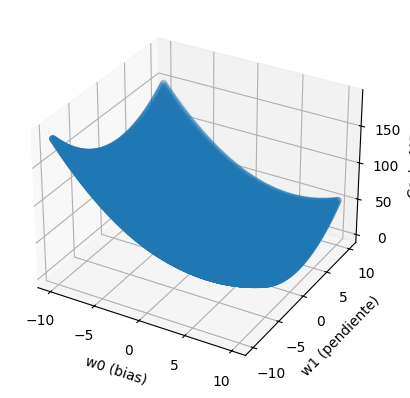

In [10]:
# Probamos con 100x100 combinaciones de distintos parametros
w0 = np.linspace(-10, 10, 100)
w1 = np.linspace(-10, 10, 100)

w0w0, w1w1 = np.meshgrid(w0, w1)

w0_flat = w0w0.ravel()
w1_flat = w1w1.ravel()

W = np.stack([w0_flat, w1_flat], axis=0)  # shape (2, 10000)


# ==============================
# CALCULAR PREDICCIONES PARA TODAS LAS W
# ==============================

# y_pred shape -> (n_samples, 10000)
y_pred = x_train @ W


# ==============================
# CALCULAR FUNCION DE COSTO PARA CADA W
# ==============================

n = y_train.shape[0]

# Expandimos y_train para broadcasting
errors = y_pred - y_train

calc_cost = (1/(2*n)) * np.sum(errors**2, axis=0)


# ==============================
# GRAFICAR
# ==============================

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(w0_flat, w1_flat, calc_cost)

ax.set_xlabel("w0 (bias)")
ax.set_ylabel("w1 (pendiente)")
ax.set_zlabel("Costo MSE")

plt.show()

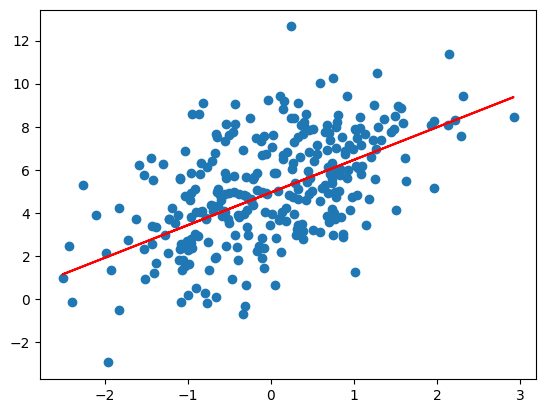

In [11]:
# Podemos encontrar la combinacion de pesos que minimizan el costo
# Y de esta manera encontrar los pesos ideales

best_idx = np.argmin(calc_cost)

search_w0 = w0_flat[best_idx]
search_w1 = w1_flat[best_idx]

search_w = np.array([[search_w0], [search_w1]])

plt.scatter(X, target_y)

# ====== Start of solution =====

# Generamos predicciones usando los mejores pesos encontrados
pred_y = X_augmented @ search_w

# Graficamos la linea de regresion
plt.plot(X, pred_y, color='red')

# ====== End of solution =====

plt.show()

En el código anterior evaluamos $100 \times 100$ combinaciones de pesos posibles y encontramos los mejores pesos. En este caso solo tenemos 2 parametros que queremos estimar, por lo que encontrar la solución de esta manera es factible al tener que realizar alrededor de $100^2$ evaluaciones de la función. 

<b>TODO: Contesta las siguientes preguntas</b> 
- ¿Cuántas evaluaciones de la función de costo tendríamos que hacer si tuviéramos 4 parametros?
- ¿Qué pasaría si tuviéramos 1 millon de parametros?

Las redes neuronales tienen millones de parametros para hacer predicciones, por lo que encontrar la solución de esta manera no es factible. Se han encontrado formas más eficientes de encontrar la solución por ejemplo, a través de métodos iterativos. Uno de ellos es decenso de gradiente. Siguiendo la direccion contraria del gradiente del costo con respecto a los pesos, podemos encontrar los parámetros que <b>minimizan</b> la función de costo utilizando menos evaluaciones.

## Descenso de gradiente
En esta sección, optimizarás la función de regresión lineal a través de descenso de gradiente.
La predicción de nuestro modelo está dada con la siguiente funcion:

$ \hat{Y}_i = w_0 + w_1 * x$

$\hat{Y} = \mathbf{X}\mathbf{w}$

<!-- El gradiente de MSE con respecto a $w_0$ se calcula de la siguiente manera

$ \frac{\partial J(w)}{\partial w_0} = \frac{\partial J(w)}{\partial \hat{Y}_i} * \frac{\partial \hat{Y}_i}{\partial w_0}= \frac{1}{n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i) $

El gradiente de MSE con respecto a $w_1$ se calcula de la siguiente manera

$ \frac{\partial J(w)}{\partial w_1} = \frac{\partial J(w)}{\partial \hat{Y}_i} * \frac{\partial \hat{Y}_i}{\partial w_1} = \frac{1}{n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i) * x_i $ -->

Donde:
- $\hat{Y}_i \in  \hat{Y}$
- $\mathbf{Y} \in \mathbb{R}^{N}$
- $\mathbf{X} \in  \mathbb{R}^{N \times D}$ en notación aumentada
- $\mathbf{w} \in \mathbb{R}^{D}$ en notación aumentada

Como vimos en clase, el gradiente la función de costo con respecto a los pesos está dado por:

 $\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}} = -\frac{1}{N}X^T\epsilon$

 donde $\epsilon=\mathbf{Y}-\mathbf{X}\mathbf{w}$

 TODO: Completa el código necesario para aplicar descenso de gradiente durante n_iteraciones. Para ello realiza los siguientes pasos:
- Calcula el valor de las predicciones $\mathbf{Y}$
- Calcula el gradiente de la función a optimizar $\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$
- Actualiza los pesos con el gradiente $\mathbf{w}^{i+1} = \mathbf{w}^{i} - \alpha \frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$
- Repite hasta optener el valor óptimo de $\mathbf{w}$

Es tiempo de programarlo en código

In [12]:



def gradient_descent(X, y, lr, N_iterations, w_start=np.array([0,0])):

    m = X.shape[0]
    w = w_start

    for i in range(N_iterations):

        # Calcular prediccion
        hypothesis = X @ w

        # Calcular error
        error = hypothesis - y

        # Calcular gradiente del MSE
        gradient = (1/m) * (X.T @ error)

        # Actualizar pesos
        w = w - lr * gradient

        # Calcular costo
        loss = mse_loss(y, hypothesis)

        print(f"Iteracion {i}, costo = {loss}")

    w_opt = w
    return w_opt

Iteracion 0, costo = 82045.57052068501
Iteracion 1, costo = 66443.5204599541
Iteracion 2, costo = 53810.53409371164
Iteracion 3, costo = 43581.21474474402
Iteracion 4, costo = 35297.9061786437
Iteracion 5, costo = 28590.148293053997
Iteracion 6, costo = 23158.052814906212
Iteracion 7, costo = 18758.850560726627
Iteracion 8, costo = 15196.004804858007
Iteracion 9, costo = 12310.400955353469
Iteracion 10, costo = 9973.216286009145
Iteracion 11, costo = 8080.149143423734
Iteracion 12, costo = 6546.748258939887
Iteracion 13, costo = 5304.632311499465
Iteracion 14, costo = 4298.429944575922
Iteracion 15, costo = 3483.302846501623
Iteracion 16, costo = 2822.9407209401866
Iteracion 17, costo = 2287.9381855823285
Iteracion 18, costo = 1854.480798859704
Iteracion 19, costo = 1503.2813002020414
Iteracion 20, costo = 1218.7183848532916
Iteracion 21, costo = 988.1394256598511
Iteracion 22, costo = 801.2959109707791
Iteracion 23, costo = 649.8863210391359
Iteracion 24, costo = 527.1859830052613
Ite

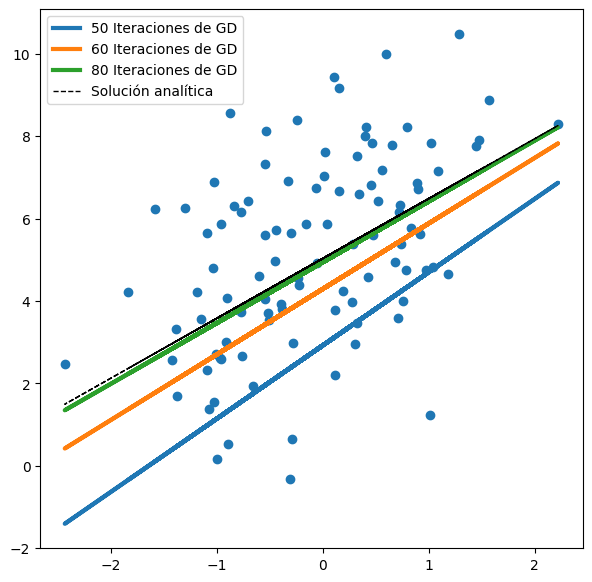

In [13]:
from sklearn import linear_model
# Parámetros de descenso de gradiente
N_iterations = [50,60,80]

# Pesos iniciales y ritmo de aprendizaje
lr = 0.1  # Utiliza valores cercanos e.g. 0.05, 0.2 .. etc
w_start = np.array([-400,0])
w_start = np.expand_dims(w_start,-1)

# (2.) - (4.) -> Variación de cantidad de iteraciones
plt.figure(figsize=(7,7))
plt.scatter(x_val[:,-1], y_val)
for n_it in N_iterations:
    # Entrenamos el modelo en el set de entrenamiento
    w_opt = gradient_descent(x_train, y_train, lr, n_it, w_start)

    # Visualizamos la predicción en el set de validación
    prediction = x_val @ w_opt
    plt.plot(x_val[:,-1], prediction, label = str(n_it)+" Iteraciones de GD", linewidth=3)

# Obtener la solución analítica
analitic_sol=linear_model.LinearRegression()
analitic_sol.fit(x_train, y_train)

# Visualizar solución analitica
plt.plot(x_val[:,-1], analitic_sol.predict(x_val),label = 'Solución analítica', linewidth=1, linestyle="dashed", color="black")
# plt.ylim(bottom=-10)
plt.legend()
plt.show()

<b>TODO: Contesta las siguientes preguntas</b> 

**- ¿Cuántas evaluaciones de la función de costo se evaluaron para encontrar la solución con un $lr=0.1$? ¿Cómo se compara este número a la solución por busqueda exhaustiva?**  

Por lo tanto, se realizaron 50, 60 y 80 evaluaciones respectivamente.

En comparacion, la busqueda exhaustiva con 2 parametros evaluando 100 valores por parametro requiere:

100^2 = 10000 evaluaciones

El descenso de gradiente es mucho mas eficiente porque necesita solo decenas de evaluaciones en lugar de miles.


**- ¿Qué pasa si cambiamos la tasa de aprendizaje (lr) a un valor dos veces grande?** 
Si el learning rate pasa de 0.1 a 0.2:

* El modelo puede converger mas rapido

* Puede empezar a oscilar

* Puede volverse inestable

* Si es demasiado grande puede divergir

Es mas rapido, pero menos estable.

**- ¿Qué pasa si cambiamos la tase de aprendizaje a un valor dos veces más chico?**  

Si el learning rate pasa de 0.1 a 0.05:

* El modelo converge mas lento

* Se necesitan mas iteraciones

* Es mas estable

* El costo disminuye de manera mas suave

Es mas estable, pero mas lento.
**- ¿Qué pasa si cambiamos la tasa de aprendizaje (lr) por un valor muy grande?**

* El costo empieza a aumentar en vez de bajar

* Los pesos saltan demasiado

* El algoritmo diverge

* No converge al minimo